In [1]:
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
import torch
import torch.nn as nn

get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

C:\Users\AtomX\AppData\Local\Temp\ipykernel_13212\983052415.py:19: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')


In [2]:
import os
import torch
import librosa
import numpy as np

import glob 
from tensorflow.keras.preprocessing.sequence import pad_sequences


emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}


def extract_features(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    rms = librosa.feature.rms(y=y)
    return np.vstack([mfcc, delta, delta2, rms]).T  # shape: (timesteps, 121)



def extract_emotion(filename):
    emotion_code = filename.split("-")[2]  # third part is emotion code
    return emotion_map.get(emotion_code, "unknown")

# Paths to speech and song folders (adjust if different)
speech_path = "Audio_Speech_Actors_01-24"
song_path   = "Audio_Song_Actors_01-24"
x=[]
y=[]
# Get all .wav files from both folders
speech_files = glob.glob(speech_path + "/**/*.wav", recursive=True)
song_files = glob.glob(song_path + "/**/*.wav", recursive=True)
all_files = speech_files + song_files

for file_path in all_files:
    label = extract_emotion(os.path.basename(file_path))
    if label is None:
        continue
    y_raw, sr = librosa.load(file_path, sr=22050)
    y_trimmed, _ = librosa.effects.trim(y_raw)

    features = extract_features(y_trimmed, sr)  # Keep (T, 121)
    x.append(features)
    y.append(label)
y = np.array(y)


In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_padded = pad_sequences(x)
arr = np.array(x_padded)

In [22]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test= train_test_split(arr, y, test_size=0.2, random_state=9)


In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
y_testencode=le.fit_transform(y_test)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label encoding:", label_map)

Label encoding: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [24]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [25]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [27]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, BatchNormalization

# Input shape: (timesteps, 121)
model = Sequential()

# CNN feature extractor
model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(x_traincnn.shape[1], x_traincnn.shape[2])))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# BiLSTM to model temporal dependencies
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))  # 8 emotion classes


C:\Users\AtomX\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 244, 128)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 244, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 240, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,920 (745.78 KB)

 Trainable params: 190,664 (744.78 KB)

 Non-trainable params: 256 (1.00 KB)

In [29]:
# # Reshape training data
#x_traincnn = x_traincnn.reshape((x_traincnn.shape[0], x_traincnn.shape[1], x_traincnn.shape[3]))



# Reshape test data
x_testcnn = x_test.reshape((x_testcnn.shape[0], x_testcnn.shape[1], x_testcnn.shape[3]))

In [30]:
print(type(x_traincnn), x_traincnn.shape)
print(type(y_train),y_train.shape)

<class 'numpy.ndarray'> (1961, 248, 1, 121)
<class 'numpy.ndarray'> (1961,)


In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Convert strings to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Step 2: One-hot encode the numeric labels
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)


In [32]:
x_traincnn = x_traincnn.reshape((x_traincnn.shape[0], 248, 121))
x_testcnn = x_testcnn.reshape((x_testcnn.shape[0], 248, 121))

In [33]:
import numpy as np

x_traincnn = np.array(x_traincnn)
x_testcnn = np.array(x_testcnn)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

Class Weights: {0: 0.8170833333333334, 1: 0.7732649842271293, 2: 1.65625, 3: 0.7958603896103896, 4: 0.8309322033898305, 5: 1.6341666666666668, 6: 0.83660409556314, 7: 1.6341666666666668}


In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 244, 128)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 244, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 240, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,920 (745.78 KB)

 Trainable params: 190,664 (744.78 KB)

 Non-trainable params: 256 (1.00 KB)

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, BatchNormalization

inputs = Input(shape=(x_traincnn.shape[1], x_traincnn.shape[2]))

x = Conv1D(128, 5, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = AttentionLayer()(x)

x = Dense(64, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 248, 121)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 244, 128)            │          77,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 244, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 240, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 120, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │             248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,968 (1.02 MB)

 Trainable params: 267,712 (1.02 MB)

 Non-trainable params: 256 (1.00 KB)

In [39]:
history = model.fit(
    x_traincnn,
    y_train_categorical,
    validation_data=(x_testcnn, y_test_categorical),
    batch_size=32,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9902 - loss: 0.0363 - val_accuracy: 0.8167 - val_loss: 0.5961 - learning_rate: 2.5000e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9916 - loss: 0.0341 - val_accuracy: 0.8228 - val_loss: 0.5545 - learning_rate: 2.5000e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.9936 - loss: 0.0310 - val_accuracy: 0.8452 - val_loss: 0.5606 - learning_rate: 2.5000e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9943 - loss: 0.0289 - val_accuracy: 0.8350 - val_loss: 0.5804 - learning_rate: 2.5000e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9896 - loss: 0.0455 - val_accuracy: 0.8391 - val_loss: 0.5637 - learning_rate: 2.5000e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9970 - loss: 0.0243 - val_accuracy: 0.8411 - val_loss: 0.5385 - learning_rate: 1.2500e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - acc

In [40]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
emotion_labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
y_pred = model.predict(x_testcnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
              precision    recall  f1-score   support

       angry       0.87      0.88      0.88        76
        calm       0.86      0.92      0.89        59
     disgust       0.88      0.80      0.83        44
     fearful       0.81      0.84      0.83        68
       happy       0.89      0.78      0.83        81
     neutral       0.83      0.92      0.88        38
         sad       0.83      0.78      0.81        83
   surprised       0.74      0.88      0.80        42

    accuracy                           0.84       491
   macro avg       0.84      0.85      0.84       491
weighted avg       0.84      0.84      0.84       491



Classification Report:
              precision    recall  f1-score   support

       angry       0.87      0.88      0.88        76
        calm       0.86      0.92      0.89        59
     disgust       0.88      0.80      0.83        44
     fearful       0.81      0.84      0.83        68
       happy       0.89      0.78      0.83        81
     neutral       0.83      0.92      0.88        38
         sad       0.83      0.78      0.81        83
   surprised       0.74      0.88      0.80        42

    accuracy                           0.84       491
   macro avg       0.84      0.85      0.84       491
weighted avg       0.84      0.84      0.84       491



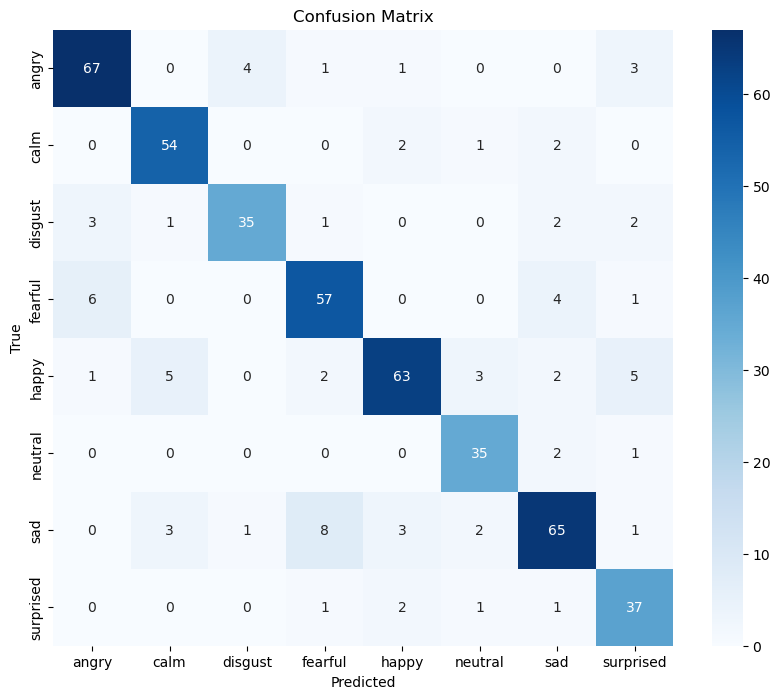

angry      Accuracy: 88.16%
calm       Accuracy: 91.53%
disgust    Accuracy: 79.55%
fearful    Accuracy: 83.82%
happy      Accuracy: 77.78%
neutral    Accuracy: 92.11%
sad        Accuracy: 78.31%
surprised  Accuracy: 88.10%


In [41]:
import seaborn as sns
emotion_labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels))
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
correct_per_class = cm.diagonal()
total_per_class = cm.sum(axis=1)
accuracy_per_class = correct_per_class / total_per_class

for idx, acc in enumerate(accuracy_per_class):
    print(f"{emotion_labels[idx]:<10} Accuracy: {acc:.2%}")

In [43]:
#Saave the Trained Model 
model.save('Emotion_classifier.h5')